### TODO

- ~~Create the AdaIN layer~~
- ~~Create the reverse VGG19 model to have the decoder, and make it trainable~~
- ~~Create a custom model~~
- ~~Create the loss function~~
- ~~Automatically log the model and its hyperparameters on each training using MLFlow
--> Create a complete training pipeline : compile the model, fit it, log it (Add experiment and tags argument in the training function for the logging)~~
- ~~Create content and style datasets from the loaded images, with automatic image resizing pipeline for the training part (and eventually 256*256 window cropping)~~
- ~~Add getters and setters when required in AdaINDataModule (for train_val_test_split especially, maybe consider using the setattr method to handle all attributes at once)~~
- ~~Add verbose steps for the training process~~
- ~~Create the AdaINTrainer~~
- ~~Log the test loss in MLflow after training~~
- Handle restart from checkpoint in AdaINTrainer
- Automatically clip the generated images to valid values

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from torchvision import transforms

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Loss
from keras.preprocessing import image, image_dataset_from_directory # type: ignore
from pathlib import Path

from adain_model import AdaINModel, instance_mean, instance_std, AdaINLoss
from adain_datamodule import AdaINDataModule

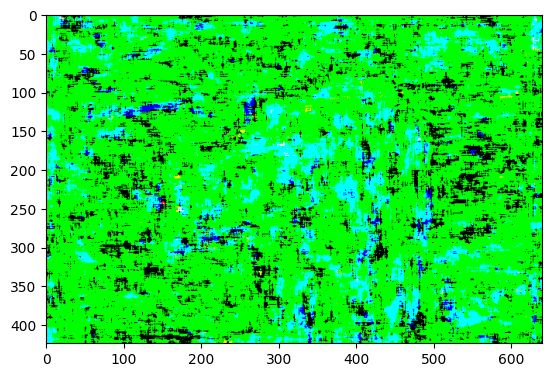

In [2]:
c = torch.tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/unlabeled2017/000000000013.jpg")))]))#.permute(1,2,0).to('cuda')
s = torch.tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/Abstract_Expressionism/alice-baber_abstract-composition-1969.jpg")))]))#.permute(1,2,0).to('cuda')
a = AdaINModel()
o = a([c,s])
plt.imshow(o.clone().detach().cpu().numpy()[0])

In [3]:
class AdaINTrainer() :
    def __init__(self, model : AdaINModel, data_module : AdaINDataModule, optimizer, mlflow_dir : Path = Path('./'), mlflow_tags : dict = {}) : #loss : AdaINLoss, optimizer) :
        self.model = model
        self.dm = data_module
        self.optimizer = optimizer
        self.mlflow_dir = mlflow_dir
        self.mlflow_tags = mlflow_tags

        self._prepared = False

    def _prepare(self) :
        print("Initiating datasets...")
        try :
            self.dm.create_datasets()
        except Exception as e :
            raise Exception(f"Could not create the datasets ({str(e)})") from None
        print("Compiling the model...")
        try :
            self.model.compile(optimizer=self.optimizer)
        except Exception as e :
            raise Exception(f"Could not compile the model ({str(e)})") from None
        
        mlflow.set_tracking_uri(self.mlflow_dir)
        mlflow.set_experiment("AdaIN Style Transfer")
        self._prepared = True
        print("Model is ready to be trained")
    
    def train(self, epochs = 1, steps_per_epoch = None) :
        if not self._prepared :
            self._prepare()
        torch.random.manual_seed(self.dm.seed) # Seed is fixed here so as to have reproducible training (especially to handle the RandomCrop transform and so to always have the same image pairs)
        print("Training the model...")
        with mlflow.start_run() as run :
            mlflow.keras.autolog(extra_tags=self.mlflow_tags, silent=True)
            history = self.model.fit(self.dm.train_dataloader(), validation_data=self.dm.val_dataloader(), epochs=epochs, steps_per_epoch=steps_per_epoch)
            print("Evaluating the model...")
            test_loss = self.model.evaluate(self.dm.test_dataloader())
            mlflow.log_metric("test_loss", test_loss)
                        
        print("The training is complete ! The model and its performances have been logged in MLFlow")

In [4]:
dm = AdaINDataModule(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/"), Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/"), dataset_size=100, seed=444, batch_size=8)
model = AdaINModel(lamb=0)

trainer = AdaINTrainer(model, dm, 'adam', mlflow_dir=Path("D:/Python/ML Flow/mlruns"), mlflow_tags={"Debugging" : True})
trainer.train(epochs=5, steps_per_epoch=10)

Initiating datasets...
Compiling the model...
Model is ready to be trained
Training the model...


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - loss: 7685.0410 - val_loss: 7857.0820
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - loss: 8029.3452 - val_loss: 7691.4951
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 488ms/step - loss: 8088.1719 - val_loss: 7813.1484
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - loss: 8035.0459 - val_loss: 7728.3267
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - loss: 8013.4160 - val_loss: 7992.6416
Evaluating the model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 8040.0806
The training is complete ! The model and its performances have been logged in MLFlow


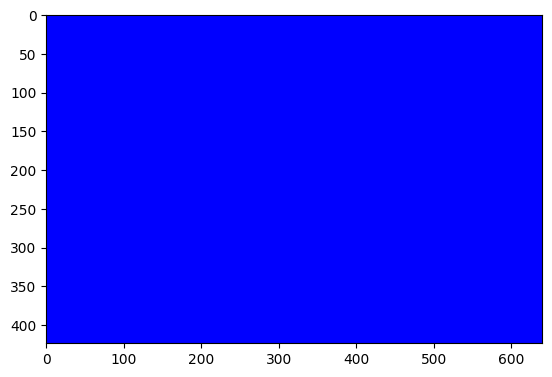

In [6]:
plt.imshow(model([c,s]).clone().detach().cpu().numpy()[0])